# Base Learning Algorithm
This notebook shows our proposed algorithm and the learning process while modeling a synthetic graphon.

## Initial Imports

In [1]:
import os
import sys

# Clones nngraphons package from GitHub in case of working from Google Colaboratory or Kaggle Kernels
CLOUD_HOSTED_ENVIRONMENT = True
if CLOUD_HOSTED_ENVIRONMENT:
    !rm -rf nngraphons
    !git clone https://github.com/honzahoang/nngraphons
    sys.path.append('./nngraphons')
else:
    sys.path.append('../nngraphons')

# Choose whether to utilize the GPU or not
# To switch to a virtual machine with GPU acceleration in Google Colab go to Runtime -> Change runtime type
# os.environ['COMPUTATION_DEVICE'] = 'cpu'
os.environ['COMPUTATION_DEVICE'] = 'cuda:0'

Cloning into 'nngraphons'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 296 (delta 146), reused 222 (delta 75), pack-reused 0
Receiving objects: 100% (296/296), 264.07 KiB | 498.00 KiB/s, done.
Resolving deltas: 100% (146/146), done.


## Ground Truth Homomorphism Density Setup

First, we sample a large graph from a synthetic graphon and approximate ground truth homomorphism densities with it.

In [2]:
from nngraphons.data_manipulation.synthetic_graphons import graphon_complete_bipartite, graphon_grow_unit_attach, graphon_constant
from nngraphons.data_manipulation.graphon_sampling import sample_synthetic_graphon
from nngraphons.data_manipulation.small_graphs import create_all_graphs
from nngraphons.learning.homomorphism_densities import t_discrete
from nngraphons.visualization.graphon_visualization import visualize_synthetic_graphon

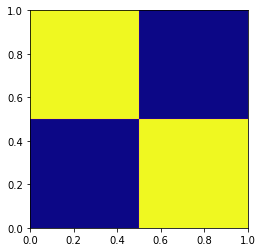

In [3]:
visualize_synthetic_graphon(graphon_complete_bipartite);

In [4]:
# Sample large graph from synthetic graphon
G_train = sample_synthetic_graphon(graphon_complete_bipartite, size=10000)

# Create finite graphs F to calculate homomorphism densities
F = create_all_graphs(n=5)

# Approximate ground truth densities
t_ground_truth = [t_discrete(F=f, G=G_train, epsilon=0.001, gamma=0.95) for f in F]
t_ground_truth

[0.4998319273058489,
 0.499574396564811,
 0.24991379497299993,
 0.0,
 0.5002683741406606,
 0.24973216802932055,
 0.12535891652750972,
 0.0,
 0.24971698726984884,
 0.12468825226084883,
 0.0,
 0.12485795146494329,
 0.0,
 0.0,
 0.5000384940686604,
 0.25032855500856627,
 0.12512740994556612,
 0.06262822320053783,
 0.0,
 0.2500829520071133,
 0.12529494046973608,
 0.0,
 0.12476415605820737,
 0.06256587365270759,
 0.0,
 0.12501897594933964,
 0.0,
 0.062335993580707426,
 0.0,
 0.062305632061764,
 0.0,
 0.062206957125197894,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

## Neural Network Definition
Here we define the network that we want to use. Let us use an fully connected MLP with skip connections and batch normalization.

In [5]:
from nngraphons.architectures.skipcon_mlp import SkipConMLP

In [16]:
# Create neural network
net = SkipConMLP(num_hidden_layers=8, hidden_size=32, init_gain=1.5)
# Set the network to do the computations on the appropriate device
net.to(os.environ['COMPUTATION_DEVICE'])

## Neural Network Training

The package provides the function `nngraphons.learning.gradient_learning.gradient_descent` but it is quite simple, so we just copy it into the cell bellow so that the user can play with it and insert their own code.

In [17]:
import torch
from IPython.display import clear_output
from nngraphons.learning.homomorphism_densities import t_nn
from nngraphons.learning.loss_functions import loss_MSE
from nngraphons.visualization.graphon_visualization import visualize_neural_network_graphon

In [ ]:
# Set the number of samples to use for homomorphism density approximation
n = 1000
# Create optimizer (underlying gradient descent algorithm)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
while True:
    # Zero out old accumulated gradients
    optimizer.zero_grad()

    # Calculate homomorphism densities w.r.t network
    t_net = [t_nn(F=f, net=net, n=n, track_computation=True) for f in F]

    # Calculate loss value
    loss = loss_MSE(t_ground_truth, t_net)

    # Progress print and visualizations
    clear_output(wait=True)
    print(f'Current loss: {loss.item()}')
    visualize_neural_network_graphon(net, resolution=150)

    # Stopping criterion
    if loss.item() < 0.000001:
        break

    # Backprop gradients
    loss.backward()

    # Update weights
    optimizer.step()

In case the learning stopped and the user would like to repeat the training process, it is advised to free up memory that the network allocated.

In [11]:
import gc

In [12]:
try:
    del net
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.memory_allocated()
except:
    pass